In [4]:
# The One-Class SVM is a modified support vector machine model that is well-suited for novelty detection (an example 
# of semi-supervised anomaly detection ). The idea is that the model trains on normal data and is used to detect 
# anomalies when new data is presented to it. While the OC-SVM might seem best suited to semi-supervised anomaly 
# detection, since training on only one class means it’s still “partially labeled” when considering the entire data 
# set, it can also be used for unsupervised anomaly detection. You will perform semi-supervised anomaly detection on 
# the same KDDCUP 1999 data set as the isolation forest example. Similar to the isolation forest, the OC-SVM is also 
# good for high-dimensional data. Additionally, the OC-SVM can capture the shape of the data set pretty well, a point 
# that will be elaborated upon below.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

%matplotlib inline

columns = ["duration", "protocol_type", "service", "flag", 
          "src_bytes", "dst_bytes", "land", "wrong_fragment",
          "urgent", "hot", "num_failed_logins", "logged_in",
          "num_compromised", "root_shell", "su_attempted",
          "num_root", "num_file_creations", "num_shells", 
          "num_access_files", "num_outbound_cmds", "is_host_login",
          "is_guest_login", "count", "srv_count", "serror_rate",
          "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
          "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
          "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
          "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
          "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
          "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
           "dst_host_srv_rerror_rate", "label"]

# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# kddcup.data.gz The full data set (18M; 743M Uncompressed)
df = pd.read_csv("./data-sample/kddcup.data", sep=",", names=columns, index_col=None)

df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

for col in df.columns:
    if df[col].dtype == 'object':
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

In [6]:
normal_encode_value = list(encoded.classes_).index("normal.")

In [20]:
novelties = df[df["label"] != normal_encode_value]
novelties_normal = df[150000: 154045]

novelties = pd.concat([novelties, novelties_normal])
normal = df[df["label"] == normal_encode_value]

In [14]:
print(novelties.shape)
print(normal.shape)

(8090, 41)
(619046, 41)


In [21]:
for f in range(0, 10):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
df2 = pd.concat([normal[:100000], normal[200000:250000]])

df_validate = normal[100000:150000]

x_train, x_test = train_test_split(df2, test_size = 0.2, random_state = 42)

x_val = df_validate    

In [22]:
print("Shapes: \nx_train: {} \n".format(x_train.shape))
print("x_test: {} \n".format(x_test.shape))
print("x_val: {} \n".format(x_val.shape))

Shapes: 
x_train: (120000, 41) 

x_test: (30000, 41) 

x_val: (50000, 41) 



In [24]:
# What you just did was use a kernel to transform the data into another dimension where there is a clear distinction between the classes of data. This mapping of data is called a kernel trick . There are different types of kernels, including the linear kernel you saw in the earlier examples. Other types of kernels include polynomial kernels, which map the data to some nth dimension using a polynomial function, and exponential kernels, which map the data according to an exponential function.

# Another term to cover is regularization , a parameter that tells the SVM how much you want to avoid misclassifications. Lower regularization values lead to graphs like the one you saw earlier where there were a few outliers on either side of the hyperplane. Higher regularization values lead to graphs where you saw the hyperplane separate every single point, at the cost of possibly overfitting on the data.

# Gamma tells the SVM how much to consider points farther away from the region of separation between the classes. Higher gamma values tell the SVM to only consider nearby points, while lower gamma values tell the SVM to also consider the points farther away.

# Finally, the margin is the separation between each class and the hyperplane. As discussed earlier, an ideal margin involves the maximum equidistant separation of each of the closest from the hyperplane. A bad margin or suboptimal margin has the hyperplane too close to one class or the distance not be as far as it can be to the hyperplane for each point or support vector.

# By default, the kernel is set to ‘rbf’, meaning radial basis function. It is similar to the circular decision boundary that you saw in the earlier examples, and you use it here because you want to define a circular boundary around a set of regions that contain normal data. As seen in the earlier examples, any points that fall outside of the region are to be considered anomalies. Gamma tells the model how much you want to consider points further from the hyperplane. Since it is pretty small, this means you want to emphasize the points farther away. The random_state is just a seed for initializing the random number generator, similar to the isolation forest model. The next parameter, nu, specifies how much of the training set contains outliers. Again, you set this to 0.1, similar to the isolation forest model. This acts similar to the regularization parameter that you saw earlier, since it tells the model approximately how many data points you expect the model to misclassify.

ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005, random_state=42, nu=0.1)

In [25]:
ocsvm.fit(x_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=42, shrinking=True, tol=0.001,
      verbose=False)

In [27]:
# One thing to note is that you can’t get the values for an AUC curve for x_test and x_validation since they comprise entirely of normal data values. You can’t get values for true negative or for false positive since there are no anomalies in the data set to classify falsely as normal or correctly as anomalies.

# Also one thing to note: Accuracy in this case is a measure of the percentage of data points in the predictions that are normal data points. Remember, you assumed that around 10% of the data points in the data set are anomalies, so the most optimal “accuracy” to obtain is 90%.

preds = ocsvm.predict(x_test)
score = 0
for f in range(0, x_test.shape[0]):
    if(preds[f] == 1):
        score = score + 1
        
accuracy = score / x_test.shape[0]
print("Test Dataset Accuracy: {:.2%}".format(accuracy))



preds = ocsvm.predict(x_val)
score = 0
for f in range(0, x_val.shape[0]):
    if(preds[f] == 1):
        score = score + 1
        
accuracy = score / x_val.shape[0]
print("Validation Dataset Accuracy: {:.2%}".format(accuracy))



Test Dataset Accuracy: 89.43%
Validation Dataset Accuracy: 89.73%


AUC: 95.91%


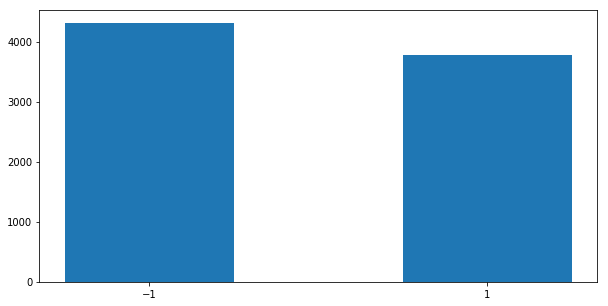

In [30]:
# This time, you can find the AUC score because there is a 50-50 split between anomalies and normal data. The other two data sets, x_test and x_validation, only had normal data, but this time it is possible for the model to classify false positives and true negatives.

from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == normal_encode_value

auc = roc_auc_score(preds, matches)
print("AUC: {:.2%}".format(auc))

plt.figure(figsize=(10, 5))
plt.hist(preds, bins=[-1.5, -0.5] + [0.5, 1.5], align='mid')
plt.xticks([-1, 1])
plt.show()
